# Step 1: Load data , import library

In [10]:
# step 1: Load data, import library
import torch,torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

#check
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

#load dataset CIFAR Color
transform=transforms.Compose([transforms.Resize((28,28)),
               transforms.ToTensor(),
               transforms.Normalize((0.5,),(0.5,))               
               ])
train_dataset=datasets.FashionMNIST(root='./data',train=True,download=True,transform=transform)
validation_dataset=datasets.FashionMNIST(root='./data',train=False,download=True,transform=transform)


         

cuda:0


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [3]:
a=[1,2,3,4,5,6]
ait=iter(a)
for i in range(6):
  print(next(ait))


  

1
2
3
4
5
6


tensor([6, 4, 7, 6, 7, 7, 8, 8, 3, 7, 1, 3, 4, 2, 1, 7, 7, 6, 1, 9, 4, 3, 8, 1,
        0, 4, 7, 9, 1, 3, 1, 4, 9, 2, 8, 7, 8, 7, 7, 1, 2, 1, 3, 2, 6, 5, 7, 6,
        4, 5, 0, 6, 0, 3, 2, 0, 6, 5, 5, 7, 6, 7, 7, 1, 4, 3, 2, 1, 7, 2, 4, 1,
        6, 1, 5, 5, 3, 6, 8, 5, 2, 5, 5, 2, 5, 7, 3, 3, 2, 9, 8, 2, 7, 0, 2, 4,
        2, 4, 3, 6])

--------[batch, color, width, high]--------
torch.Size([100, 1, 28, 28])


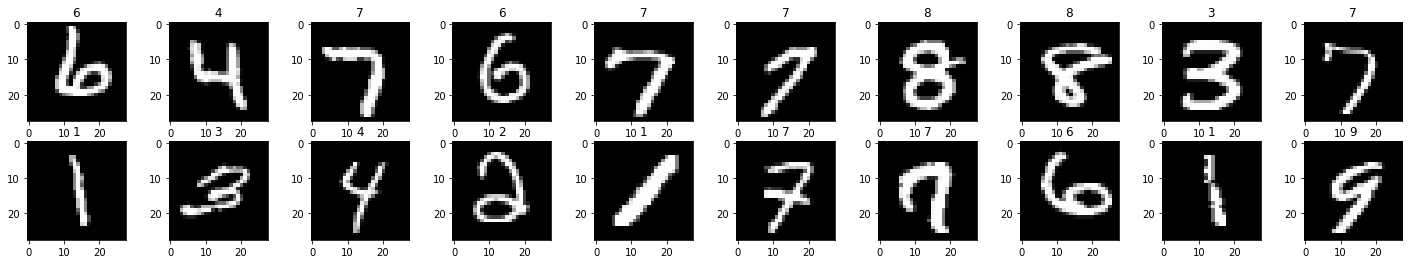

In [4]:
#step 2 :  Preprocessing
#datasets processing
training_loader=torch.utils.data.DataLoader(train_dataset, batch_size=100,shuffle=True)
validation_loader=torch.utils.data.DataLoader(validation_dataset, batch_size=100,shuffle=True)

#iter -> 一次一個資料
data_out=iter(training_loader)
inputs,labels=data_out.next() #下一筆資料
print(labels)
print('\n--------[batch, color, width, high]--------')
print(inputs.size())

#image processing
fig=plt.figure(figsize=(25,4))
for idx in np.arange(20):
  ax=fig.add_subplot(2,10,idx+1)
  plt.imshow(inputs[idx].reshape(28,28), cmap="gray")
  ax.set_title(labels[idx].item())
  

## DNN
<img src= "https://miro.medium.com/max/415/1*6AxEGdJGViO8oF-YPXkQag.png" width=400 />


## LeNet5
<img src="https://miro.medium.com/max/1000/1*vUJ-XilD6_WECeQlOMThMQ.png" width=500 />


In [5]:
#step 3: build model
class LeNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 20, 5, 1)
    self.conv2 = nn.Conv2d(20, 50, 5, 1)
    self.fc1 = nn.Linear(4*4*50, 500)
    self.dropout1 = nn.Dropout(0.5)
    self.fc2 = nn.Linear(500, 10)
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = x.view(-1, 4*4*50)
    x = F.relu(self.fc1(x))
    x = self.dropout1(x)
    x = self.fc2(x)
    return x

class MyDNN(nn.Module):
  def __init__(self,inSize,h1Size,h2Size,outSize):
    super().__init__()
    self.linear1=nn.Linear(inSize,h1Size)
    self.linear2=nn.Linear(h1Size,h2Size)
    self.linear3=nn.Linear(h2Size,outSize)
  def forward(self,x):
      x=F.relu(self.linear1(x))
      x=F.relu(self.linear2(x))
      x=self.linear3(x)
      return x



In [6]:
#vgg16 too big for training

#model=MyDNN(784,128,64,10)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model =LeNet().to(device)
print(model)
 

LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)


In [15]:
#step 4 training
criterion=nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)
epochs = 5
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    #inputs = inputs.view(inputs.shape[0], -1)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
############ 梯  度  下  降 ############  
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
#######################################

    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

  else: #for else -> else只在最後一次迴圈後執行
    with torch.no_grad(): #with 之內的 gradient都關掉
      for val_inputs, val_labels in validation_loader:
        #val_inputs = val_inputs.view(val_inputs.shape[0], -1)
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
      
    # 統計用
    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_corrects.float()/ len(training_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc.item())
    
    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc.item())
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))


epoch : 1
training loss: 0.0338, acc 98.9450 
validation loss: 0.0309, validation acc 99.0100 
epoch : 2
training loss: 0.0311, acc 99.0600 
validation loss: 0.0349, validation acc 98.9000 
epoch : 3
training loss: 0.0290, acc 99.1500 
validation loss: 0.0325, validation acc 98.9000 
epoch : 4
training loss: 0.0258, acc 99.1850 
validation loss: 0.0320, validation acc 98.9700 
epoch : 5
training loss: 0.0252, acc 99.1983 
validation loss: 0.0306, validation acc 99.0500 


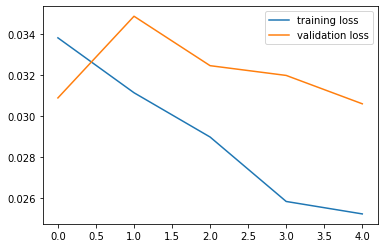

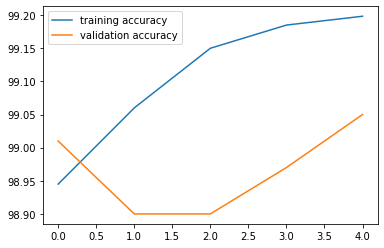

In [16]:
plt.plot(running_loss_history,label='training loss')
plt.plot(val_running_loss_history,label='validation loss')
plt.legend()
plt.show()
plt.plot(running_corrects_history,label='training accuracy')
plt.plot(val_running_corrects_history,label='validation accuracy')
plt.legend()
plt.show()

In [19]:
!pip3 install pillow==4.0.0
import PIL.ImageOps
import requests
from PIL import Image

def im_convert(tensor):
  image = tensor.clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

url = 'https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)
img = PIL.ImageOps.invert(img)
img = img.convert('1')
img = transform(img) 
plt.imshow(im_convert(img))
plt.show()
img = img.view(img.shape[0], -1)
output = model(img)
_, pred = torch.max(output, 1)
print(pred.item())
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images_ = images.view(images.shape[0], -1)
output = model(images_)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color=("green" if preds[idx]==labels[idx] else "red"))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


AttributeError: ignored

### CPU to GPU 

In [20]:
!/opt/bin/nvidia-smi

# 範例
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
#https://zhuanlan.zhihu.com/p/254738836
#Assign cuda GPU located at location '0' to a variable
cuda0 = torch.device('cuda:0')
#Performing the addition on GPU

a = torch.ones(3, 2, device=cuda0) #creating a tensor 'a' on GPU
b = torch.ones(3, 2, device=cuda0) #creating a tensor 'b' on GPU
c = a + b
print(c)
#moving the result to cpu
c = c.cpu()
print(c)




Wed Nov 23 12:51:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    31W /  70W |   1178MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Tensorboard